In [ ]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
tcmalloc: large alloc 1821458432 bytes == 0x3450000 @  0x7f21d81791e7 0x4b2590 0x5ad01c 0x5dcfef 0x58f92b 0x590c33 0x5e48ac 0x4d20fa 0x51041f 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x4bad0a 0x4d3249
tcmalloc: large alloc 1821458432 bytes == 0x6fd64000 @  0x7f21d81791e7 0x4b2590 0x5ad01c 0x64b047 0x4d22a6 0x51041f 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6
tcmalloc: large alloc 1821458432 bytes == 0xdc

In [ ]:
# Import the game
import gym_super_mario_bros # import to make an environment
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation # wrapper that converts a color observation to grayscale
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros2-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros2-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
state = env.reset()

In [ ]:
state, reward, done, info = env.step([5])

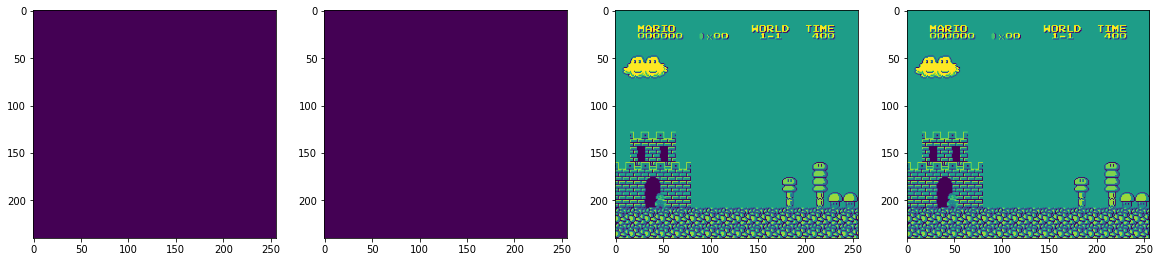

In [ ]:
# Visualizing Map
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [ ]:
CHECKPOINT_DIR = 'train'
LOG_DIR = 'logs'

In [ ]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [ ]:
# AI model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Training the model 
model.learn(total_timesteps=1000, callback=callback)

Logging to logs/PPO_4
----------------------------
| time/              |     |
|    fps             | 20  |
|    iterations      | 1   |
|    time_elapsed    | 25  |
|    total_timesteps | 512 |
----------------------------


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-------------------------------------------
| time/                   |               |
|    fps                  | 7             |
|    iterations           | 2             |
|    time_elapsed         | 143           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.4831657e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.000339     |
|    learning_rate        | 1e-06         |
|    loss                 | 35.7          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000121     |
|    value_loss           | 110           |
-------------------------------------------


In [ ]:
# Model Save
model.save('mariooo')

In [ ]:
# Model load
model = PPO.load('/content/mariooo.zip')

In [ ]:
state = env.reset()

In [ ]:
# Recording Agent
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros2-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(4000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

Exception ignored in: <function Monitor.__del__ at 0x7fd88fdba3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 289, in __del__
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 178, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/nes_py/nes_env.py", line 346, in close
ValueError: env has already been closed.
/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [ ]:
# Watching Agent
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

**References**

https://pypi.org/project/gym-super-mario-bros/ - for different environment

https://github.com/nicknochnack/MarioRL - link for the code

